<a href="https://colab.research.google.com/github/nshea3/SEG_Facies_Classification/blob/master/SEG_Facies_Classification_Archie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

data = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/training_data.csv')


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold , StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import medfilt

In [3]:
#Load Data
data = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/facies_vectors.csv')

data['logF/logphi'] = data['ILD_log10'] / np.log10(data['PHIND'])

# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'logF/logphi']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

# Store features and labels
X = data[feature_names].values 
y = data['Facies'].values 

# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values

# Fill 'PE' missing values with mean
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [0]:
X_aug, padded_rows = augment_features(X, well, depth)

In [0]:
def preprocess():
    
    # Preprocess data to use in model
    X_train_aux = []
    X_test_aux = []
    y_train_aux = []
    y_test_aux = []
    
    # For each data split
    split = split_list[5]
        
    # Remove padded rows
    split_train_no_pad = np.setdiff1d(split['train'], padded_rows)

    # Select training and validation data from current split
    X_tr = X_aug[split_train_no_pad, :]
    X_v = X_aug[split['val'], :]
    y_tr = y[split_train_no_pad]
    y_v = y[split['val']]

    # Select well labels for validation data
    well_v = well[split['val']]

    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
        
    X_train_aux.append( X_tr )
    X_test_aux.append( X_v )
    y_train_aux.append( y_tr )
    y_test_aux.append (  y_v )
    
    X_train = np.concatenate( X_train_aux )
    X_test = np.concatenate ( X_test_aux )
    y_train = np.concatenate ( y_train_aux )
    y_test = np.concatenate ( y_test_aux )
    
    return X_train , X_test , y_train , y_test

In [0]:
from sklearn.ensemble import  RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier

In [0]:
def train_and_test(X_tr, y_tr, X_v, well_v, clf):
    
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
    
    clf.fit(X_tr, y_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    for w in np.unique(well_v):
        y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=5)
    
    return y_v_hat

In [0]:
test_data = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/validation_data_nofacies.csv')

In [26]:
#Load testing data

    # Train classifier
    #clf = make_pipeline(make_union(VotingClassifier([("est", ExtraTreesClassifier(criterion="gini", max_features=1.0, n_estimators=500))]), FunctionTransformer(lambda X: X)), XGBClassifier(learning_rate=0.73, max_depth=10, min_child_weight=10, n_estimators=500, subsample=0.27))
    #clf =  make_pipeline( KNeighborsClassifier(n_neighbors=5, weights="distance") ) 
    #clf = make_pipeline(MaxAbsScaler(),make_union(VotingClassifier([("est", RandomForestClassifier(n_estimators=500))]), FunctionTransformer(lambda X: X)),ExtraTreesClassifier(criterion="entropy", max_features=0.0001, n_estimators=500))
    # * clf = make_pipeline( make_union(VotingClassifier([("est", BernoulliNB(alpha=60.0, binarize=0.26, fit_prior=True))]), FunctionTransformer(lambda X: X)),RandomForestClassifier(n_estimators=500))

# # Prepare training data
# X_tr = X
# y_tr = y

# # Augment features
# X_tr, padded_rows = augment_features(X_tr, well, depth)

# # Removed padded rows
# X_tr = np.delete(X_tr, padded_rows, axis=0)
# y_tr = np.delete(y_tr, padded_rows, axis=0) 

# Prepare test data

test_data['logF/logphi'] = test_data['ILD_log10'] / np.log10(test_data['PHIND'])

well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values


    
y_pred = []
print('.' * 20)
for seed in range(20):
    np.random.seed(seed)

    # Make training data.
    X_train, padded_rows = augment_features(X, well, depth)
    y_train = y
    X_train = np.delete(X_train, padded_rows, axis=0)
    y_train = np.delete(y_train, padded_rows, axis=0) 

    # Train classifier  
    clf = make_pipeline(XGBClassifier(learning_rate=0.12,
                                      max_depth=5,
                                      min_child_weight=10,
                                      n_estimators=175,
                                      seed=seed,
                                      colsample_bytree=0.9))

    # Make blind data.
    X_test, _ = augment_features(X_ts, well_ts, depth_ts)

    # Train and test.
    y_ts_hat = train_and_test(X_train, y_train, X_test, well_ts, clf)
    
    # Collect result.
    y_pred.append(y_ts_hat)
    print('|', end='')
    
np.save('LA_Team_100_realizations.npy', y_pred)

....................
||||||||||||||||||||

In [0]:
from sklearn.metrics import confusion_matrix

PRED = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/prediction_depths.csv')
PRED.set_index(["Well Name", "Depth"], inplace=True)
PRED.head()

TRUE = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/blind_stuart_crawford_core_facies.csv')
TRUE.rename(columns={'Depth.ft': 'Depth'}, inplace=True)
TRUE.rename(columns={'WellName': 'Well Name'}, inplace=True)
TRUE.set_index(["Well Name", "Depth"], inplace=True)
TRUE.head()


def get_accuracies(y_preds):
    """
    Get the F1 scores from all the y_preds.
    y_blind is a 1D array. y_preds is a 2D array.
    """
    accs = []
    for y_pred in y_preds:
        PRED['Facies'] = y_pred
        all_data = PRED.join(TRUE, how='inner')
        y_blind = all_data['LithCode'].values
        y_pred = all_data['Facies'].values
        y_pred = y_pred[y_blind!=11]
        y_blind = y_blind[y_blind!=11]
        cv_conf = confusion_matrix(y_blind, y_pred)
        #sns.heatmap(cv_conf, annot=True, fmt="d")
        accs.append(accuracy(cv_conf))
    return np.array(accs)

LA                  0.6350


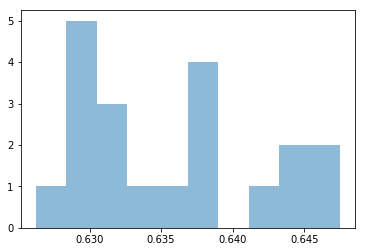

In [28]:
from os import path
import operator


def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

scores, medians = {}, {}
for f in ['LA_Team_100_realizations.npy']:
    team = path.basename(f).split('_')[0]
    y_preds = np.load(f)
    scores[team] = get_accuracies(y_preds)
    medians[team] = np.median(scores[team])
    plt.hist(pd.Series(scores[team]), alpha=0.5)

for t, m in sorted(medians.items(), key=operator.itemgetter(1), reverse=True):
    print("{:20s}{:.4f}".format(t, m))